In [1]:
import numpy as np
import statsmodels.api as sm
from scipy import stats
from scipy.special import loggamma
import matplotlib.pyplot as plt

In [1]:
import torch
from torch_geometric.data import Data

ImportError: dlopen(/Users/zihanzhao/Documents/anaconda3/lib/python3.12/site-packages/torch/_C.cpython-312-darwin.so, 0x0002): Library not loaded: @rpath/liblapack.3.dylib
  Referenced from: <5BC09ACF-F7D0-31EF-B863-0779C73CDBF4> /Users/zihanzhao/Documents/anaconda3/lib/libtorch_cpu.dylib
  Reason: tried: '/Users/zihanzhao/Documents/anaconda3/lib/liblapack.3.dylib' (no such file), '/Users/zihanzhao/Documents/anaconda3/lib/liblapack.3.dylib' (no such file), '/Users/zihanzhao/Documents/anaconda3/lib/liblapack.3.dylib' (no such file), '/Users/zihanzhao/Documents/anaconda3/lib/liblapack.3.dylib' (no such file), '/Users/zihanzhao/Documents/anaconda3/lib/liblapack.3.dylib' (no such file), '/Users/zihanzhao/Documents/anaconda3/lib/liblapack.3.dylib' (no such file), '/Users/zihanzhao/Documents/anaconda3/lib/python3.12/site-packages/torch/lib/liblapack.3.dylib' (no such file), '/Users/zihanzhao/Documents/anaconda3/lib/python3.12/site-packages/torch/../../../liblapack.3.dylib' (no such file), '/Users/zihanzhao/Documents/anaconda3/lib/python3.12/site-packages/torch/lib/liblapack.3.dylib' (no such file), '/Users/zihanzhao/Documents/anaconda3/lib/python3.12/site-packages/torch/../../../liblapack.3.dylib' (no such file), '/Users/zihanzhao/Documents/anaconda3/bin/../lib/liblapack.3.dylib' (no such file), '/Users/zihanzhao/Documents/anaconda3/bin/../lib/liblapack.3.dylib' (no such file), '/usr/local/lib/liblapack.3.dylib' (no such file), '/usr/lib/liblapack.3.dylib' (no such file, not in dyld cache)

In [3]:
C_N = 0
for i in range(1,(d+1)):
    C_N += 1/i
C_N

3.9949871309203906

In [46]:
np.arange(1,(2 + 1))

array([1, 2])

In [4]:
nulls = np.arange(10,30)
def Bonferroni(p_set):
    rejected = np.where(p_set < alpha/d)[0]
    num = len(rejected)
    FDP = np.sum(np.isin(rejected, nulls)) / max(1, len(rejected))
    return num, FDP

def BY(p_set,C_N):
    p_set = np.sort(p_set)
    threshold = alpha/(C_N*d)
    rejected = []
    ratios = [p_set[i] / (i + 1) for i in range(len(p_set))]
    rejected = [i + 1 for i, ratio in enumerate(ratios) if ratio <= threshold]
    FDP = np.sum(np.isin(rejected, nulls)) / max(1, len(rejected))
    return len(rejected), FDP

# Got the Tj from Linear Model
def EV_test(m,T):
    c = m * np.log(n - d) + loggamma(1/2 + m) + loggamma((n-d)/2 - m) - loggamma(1/2) - loggamma((n-d)/2)
    c = np.exp(-c)
    M = T**(2*m)
    E = c * M
    E = np.sort(E)[::-1]
    rejected = []
    for i in range(len(E)):
        e_i = (i+1) * E[i]
        if e_i >= d/alpha:
            rejected.append(e_i)
    FDP = np.sum(np.isin(rejected, nulls)) / max(1, len(rejected))
    return len(rejected), FDP

In [5]:
for time in range(1000):
# use the multivariate_normal distribution instead of using 3 different normal distribution ! 
    X = np.random.multivariate_normal(np.zeros(d), np.eye(d), size=n)
# np.random.normal(mean, std, num), the variance is 0.01 so the std is 0.1   
    beta_10 = np.random.normal(0,0.1,10)
    beta_last = np.array([0]*20)
    beta = np.concatenate((beta_10, beta_last)) # combine two different array
    beta = beta.reshape(30,1)
    epsilon = np.random.normal(0,1,(n,1))

    Y = X @ beta + epsilon

    X2 = sm.add_constant(X)
    model = sm.OLS(Y, X2)
    model2 = model.fit()
# predictive epsilon and beta
    epsilon_hat = Y - model2.predict(X2)
    beta_hat = model2.params[1:]
# p_value for beta_hat
    p_set = model2.pvalues[1:]
    T = model2.tvalues[1:]
# BF test:   
    BF_rejected, BF_FDP = Bonferroni(p_set)
    BF_num.append(BF_rejected)
    BF_fdp.append(BF_FDP)
# BY test:
    BY_rejected, BY_FDP = BY(p_set,C_N)
    BY_num.append(BY_rejected)
    BY_fdp.append(BY_FDP)

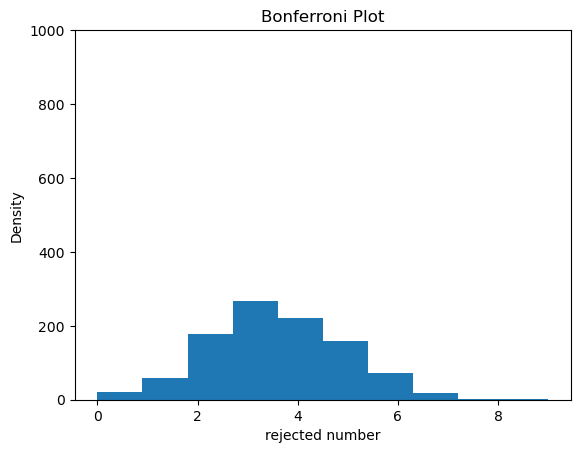

In [129]:
# BF result
import matplotlib.pyplot as plt
plt.hist(BF_num)
plt.xlabel("rejected number")
plt.ylabel("Density")
plt.title("Bonferroni Plot")
plt.ylim(0,1000)
plt.show()

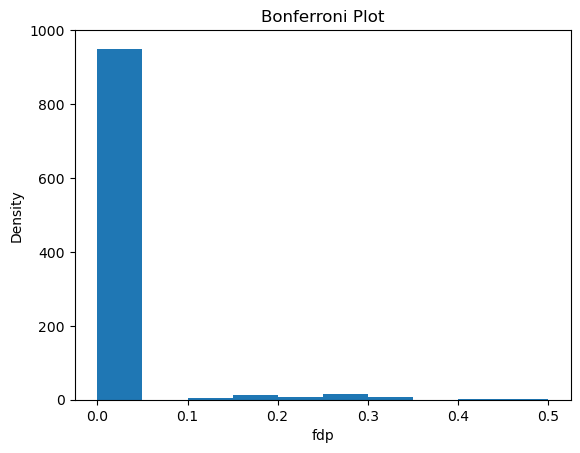

In [11]:
plt.hist(BF_fdp)
plt.xlabel("fdp")
plt.ylabel("Density")
plt.title("Bonferroni Plot")
plt.ylim(0,1000)
plt.show()

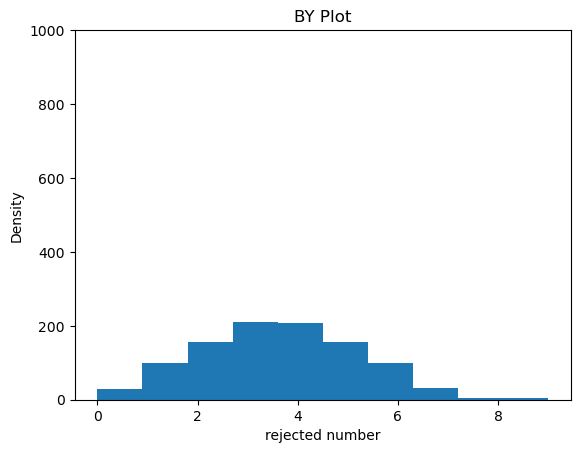

In [39]:
plt.hist(BY_num)
plt.xlabel("rejected number")
plt.ylabel("Density")
plt.title("BY Plot")
plt.ylim(0,1000)
plt.show()

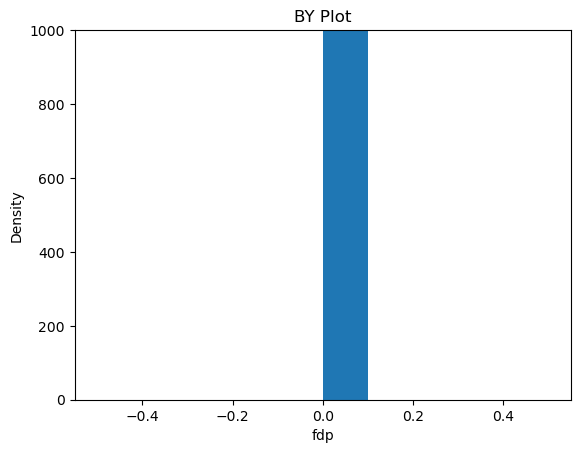

In [6]:
plt.hist(BY_fdp)
plt.xlabel("fdp")
plt.ylabel("Density")
plt.title("BY Plot")
plt.ylim(0,1000)
plt.show()

In [137]:
# EV test
EV_num = []
EV_fdp = []
for time in range(1000):
    X = np.random.multivariate_normal(np.zeros(d), np.eye(d), size=n)
# np.random.normal(mean, std, num), the variance is 0.01 so the std is 0.1   
    beta_10 = np.random.normal(0,0.1,10)
    beta_last = np.array([0]*20)
    nulls = np.arange(10,30)
    beta = np.concatenate((beta_10, beta_last)) # combine two different array
    beta = beta.reshape(30,1)
    epsilon = np.random.normal(0,1,(n,1))

    Y = X @ beta + epsilon
    X2 = sm.add_constant(X)
    model = sm.OLS(Y, X2)
    model2 = model.fit()
# predictive epsilon and beta
    epsilon_hat = Y - model2.predict(X2)
    beta_hat = model2.params[1:]
# p_value for beta_hat
    p_set = model2.pvalues[1:]
    T_val = model2.tvalues[1:]

    EV_rejected, EV_FDP = EV_test(m=2,beta_hat = beta_hat,epsilon_hat = epsilon_hat,T=T_val)

    EV_num.append(EV_rejected)
    EV_fdp.append(EV_FDP)

In [138]:
from collections import Counter
total_num = Counter(EV_num)
total_num

Counter({0: 346, 1: 236, 2: 178, 3: 122, 4: 64, 5: 35, 6: 11, 7: 8})

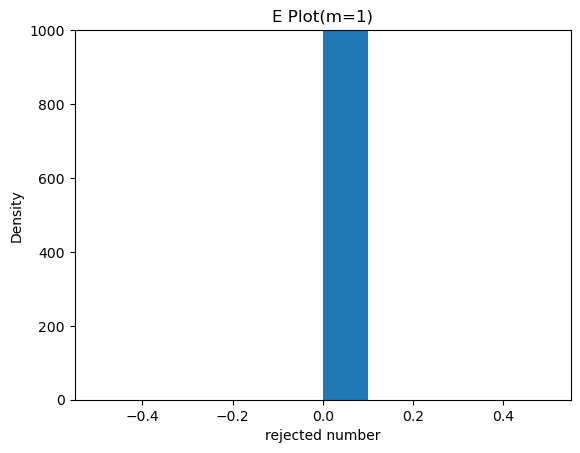

In [105]:
plt.hist(EV_num)
plt.xlabel("rejected number")
plt.ylabel("Density")
plt.title("E Plot(m=1)")
plt.ylim(0,1000)
plt.show()

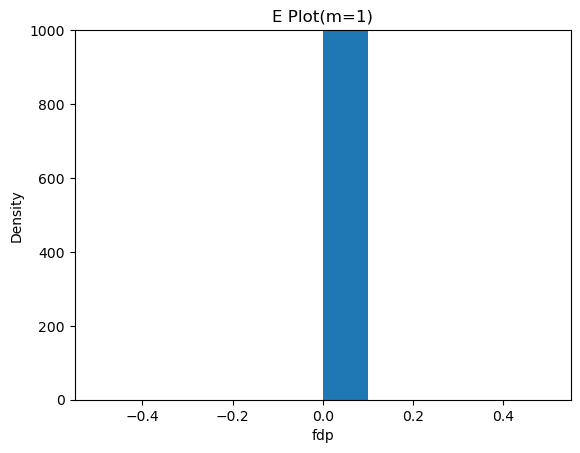

In [106]:
plt.hist(EV_fdp)
plt.xlabel("fdp")
plt.ylabel("Density")
plt.title("E Plot(m=1)")
plt.ylim(0,1000)
plt.show()

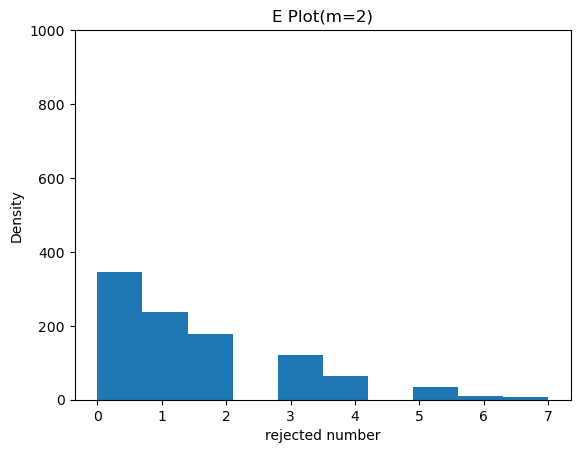

In [139]:
plt.hist(EV_num)
plt.xlabel("rejected number")
plt.ylabel("Density")
plt.title("E Plot(m=2)")
plt.ylim(0,1000)
plt.show()